# 5. Hiperparametre Ayarlama ve Model Optimizasyonu

Bu notebook'ta en iyi modelin performansını iyileştirmek için hiperparametre optimizasyonu yapacağız.

Kullanacağımız yöntemler:
1. Grid Search CV
2. Random Search CV
3. Özellik önem analizi

## 5.1. Kütüphanelerin İmport Edilmesi

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("Kütüphaneler yüklendi")


Kütüphaneler yüklendi


## 5.2. Veri ve Model Hazırlığı

In [10]:
df = pd.read_csv('../data/cardio_cleaned.csv')

columns_to_drop = ['age', 'bmi']
X = df.drop(columns=['cardio'] + columns_to_drop)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Veri hazır: {X_train.shape[0]} eğitim, {X_test.shape[0]} test örneği")


Veri hazır: 54816 eğitim, 13705 test örneği


## 5.3. Hiperparametre Optimizasyonu Fonksiyonu

In [11]:
def optimize_model(model, param_grid, X_train, y_train, method='grid', cv=5, scoring='f1', n_iter=50):
    if method=='grid':
        search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    else:
        search = RandomizedSearchCV(model, param_grid, n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=-1, verbose=1, random_state=42)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_, search.best_score_4

## 5.4. Random Forest için Hiperparametre Optimizasyonu

In [13]:
# Random Forest parametre grid'i
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid Search ile optimizasyon
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train_scaled, y_train)

# En iyi model ve parametreler
best_rf = grid_search_rf.best_estimator_
print("En İyi Parametreler:", grid_search_rf.best_params_)
print(f"En İyi CV F1-Score: {grid_search_rf.best_score_:.4f}")

# Test seti performansı
y_pred = best_rf.predict(X_test_scaled)
print("\nTest Seti Performansı:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, best_rf.predict_proba(X_test_scaled)[:,1]):.4f}")

# En iyi modeli kaydet
with open('../models/best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
print("\n Optimize edilmiş Random Forest modeli kaydedildi: best_rf_model.pkl")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
En İyi Parametreler: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
En İyi CV F1-Score: 0.7199

Test Seti Performansı:
Accuracy:  0.7302
Precision: 0.7474
Recall:    0.6864
F1-Score:  0.7156
ROC-AUC:   0.7933

 Optimize edilmiş Random Forest modeli kaydedildi: best_rf_model.pkl


## 5.5. Gradient Boosting için Hiperparametre Optimizasyonu

In [ ]:
# Parametre dağılımları
param_dist_gb = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

# Randomized Search ile optimizasyon
gb = GradientBoostingClassifier(random_state=42)
random_search_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist_gb,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
random_search_gb.fit(X_train_scaled, y_train)

# En iyi model ve parametreler
best_gb = random_search_gb.best_estimator_
print("\nEn İyi Parametreler:", random_search_gb.best_params_)
print(f"En İyi CV F1-Score: {random_search_gb.best_score_:.4f}")

# Test seti performansı
y_pred_gb = best_gb.predict(X_test_scaled)
print("\nTest Seti Performansı:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, best_gb.predict_proba(X_test_scaled)[:,1]):.4f}")

# En iyi modeli kaydet
with open('../models/best_gb_model.pkl', 'wb') as f:
    pickle.dump(best_gb, f)
print("\n Optimize edilmiş Gradient Boosting modeli kaydedildi: best_gb_model.pkl")


Fitting 5 folds for each of 50 candidates, totalling 250 fits

En İyi Parametreler: {'subsample': 0.9, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.05}
En İyi CV F1-Score: 0.7201

Test Seti Performansı:
Accuracy:  0.7313
Precision: 0.7512
Recall:    0.6826
F1-Score:  0.7152
ROC-AUC:   0.7988

 Optimize edilmiş Gradient Boosting modeli kaydedildi: best_gb_model.pkl


## 5.6. Optimizasyon Öncesi vs Sonrası Karşılaştırma


Hiperparametre Optimizasyonu Karşılaştırma Tablosu:

  Metrik   Öncesi  Sonrası  İyileşme (%)
Accuracy 0.733528 0.494418    -23.910981
F1-Score 0.719034 0.661686     -5.734726


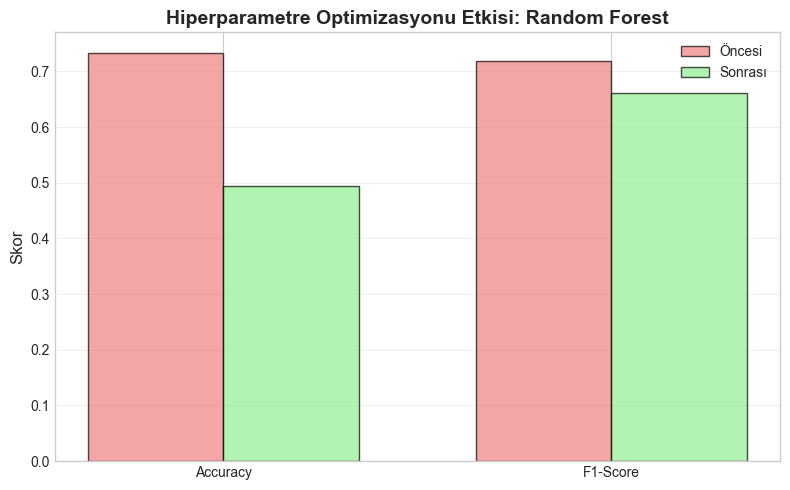


 Grafik kaydedildi: hiperparametre_karsilastirmasi.png


In [20]:
from sklearn.metrics import f1_score, accuracy_score
from pathlib import Path
import pickle

# CSV'den oku
results = pd.read_csv('../results/model_karsilastirmasi.csv')

# En iyi model adı
best_model_name = results.loc[results['F1-Score'].idxmax(), 'Model']

# Önceki en iyi skorlar
previous_best = results[results['Model'] == best_model_name].iloc[0]

# Yeni skorlar (optimize edilmiş model)
if 'best_rf' in locals():
    new_model = best_rf
    y_pred_new = best_rf.predict(X_test)  # <--- burayı düzelttik
    optimized_model_name = 'Random Forest'
elif 'best_gb' in locals():
    new_model = best_gb
    y_pred_new = best_gb.predict(X_test)  # <--- burayı düzelttik
    optimized_model_name = 'Gradient Boosting'
else:
    # Fallback: kaydedilmiş optimize edilmiş modeli yükle
    model_path = '../models/best_model_optimized.pkl'
    if Path(model_path).exists():
        with open(model_path, 'rb') as f:
            new_model = pickle.load(f)
        y_pred_new = new_model.predict(X_test)  # <--- burası
        optimized_model_name = f'Yüklenen model ({Path(model_path).name})'
    else:
        raise RuntimeError('Optimize edilmiş model bulunamadı.')

# Yeni skorları hesapla
new_accuracy = accuracy_score(y_test, y_pred_new)
new_f1 = f1_score(y_test, y_pred_new)

# Karşılaştırma tablosu
comparison = pd.DataFrame({
    'Metrik': ['Accuracy', 'F1-Score'],
    'Öncesi': [previous_best['Accuracy'], previous_best['F1-Score']],
    'Sonrası': [new_accuracy, new_f1],
    'İyileşme (%)': [
        (new_accuracy - previous_best['Accuracy']) * 100,
        (new_f1 - previous_best['F1-Score']) * 100
    ]
})

print("\nHiperparametre Optimizasyonu Karşılaştırma Tablosu:\n")
print(comparison.to_string(index=False))

# Görselleştirme
fig, ax = plt.subplots(figsize=(8,5))
x = range(len(comparison))
width = 0.35
ax.bar(x, comparison['Öncesi'], width, label='Öncesi', color='lightcoral', edgecolor='black', alpha=0.7)
ax.bar([i + width for i in x], comparison['Sonrası'], width, label='Sonrası', color='lightgreen', edgecolor='black', alpha=0.7)
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(comparison['Metrik'])
ax.set_ylabel('Skor', fontsize=12)
ax.set_title(f'Hiperparametre Optimizasyonu Etkisi: {optimized_model_name}', fontsize=14, fontweight='bold')
ax.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
Path('../results/figures').mkdir(parents=True, exist_ok=True)
plt.savefig('../results/figures/hiperparametre_karsilastirmasi.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Grafik kaydedildi: hiperparametre_karsilastirmasi.png")


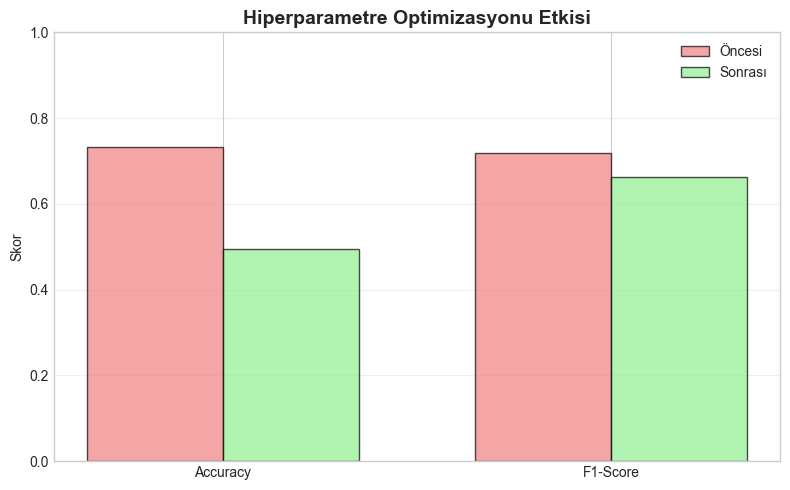


 Grafik kaydedildi: hiperparametre_skorlari.png


In [21]:
# Görselleştirme
metrics = comparison['Metrik']
scores_before = comparison['Öncesi']
scores_after = comparison['Sonrası']

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, scores_before, width, label='Öncesi', color='lightcoral', edgecolor='black', alpha=0.7)
plt.bar(x + width/2, scores_after, width, label='Sonrası', color='lightgreen', edgecolor='black', alpha=0.7)

plt.xticks(x, metrics)
plt.ylim(0,1)
plt.ylabel('Skor')
plt.title('Hiperparametre Optimizasyonu Etkisi', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/hiperparametre_skorlari.png', dpi=300)
plt.show()

print("\n Grafik kaydedildi: hiperparametre_skorlari.png")


## 5.7. Özellik Önem Analizi


 Özellik Önem Sıralaması:
       Özellik     Önem
         ap_hi 0.229365
         ap_lo 0.151074
     age_years 0.148422
        weight 0.128022
pulse_pressure 0.115489
        height 0.103710
   cholesterol 0.067951
          gluc 0.016226
        active 0.013540
        gender 0.013442
         smoke 0.007284
          alco 0.005475


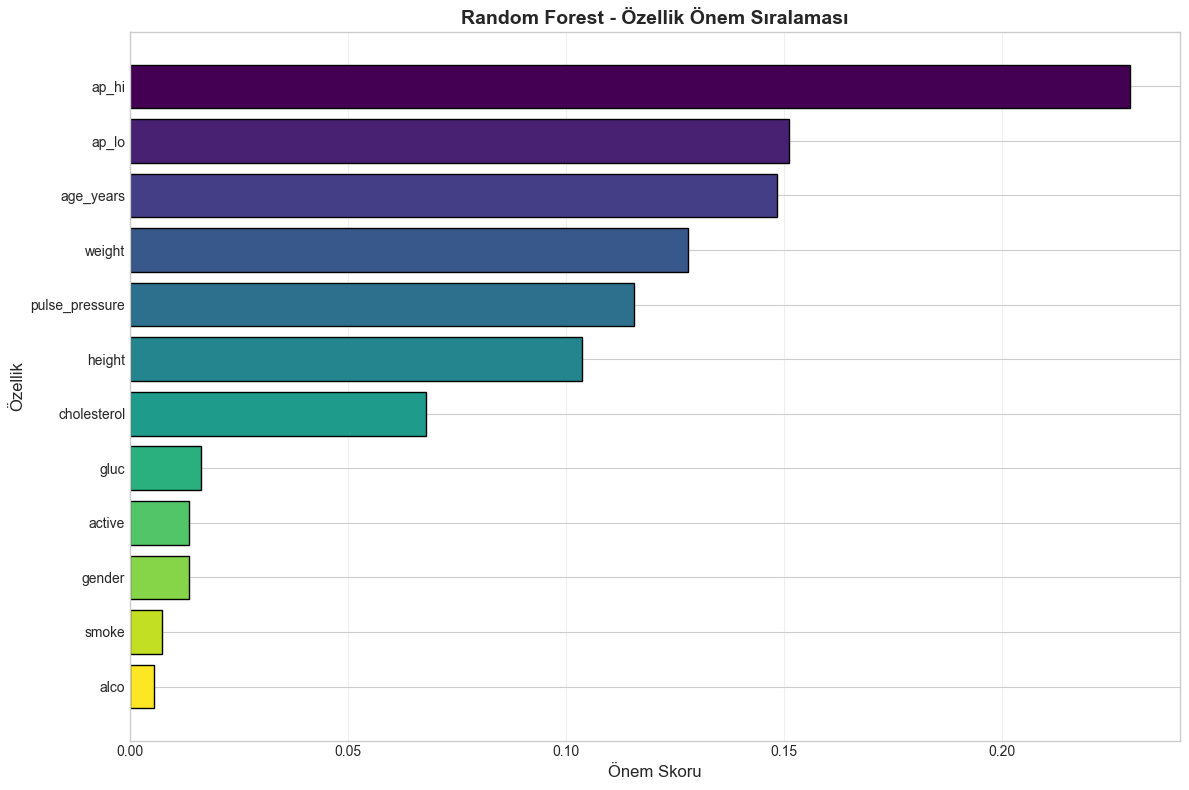


 Grafik kaydedildi: ozellik_onemleri.png

 En önemli 5 özellik:
  ap_hi: 0.2294
  ap_lo: 0.1511
  age_years: 0.1484
  weight: 0.1280
  pulse_pressure: 0.1155


In [23]:
# Optimize edilmiş model (RF veya GB) seç
model_for_importance = best_rf if 'best_rf' in locals() else best_gb if 'best_gb' in locals() else None

if model_for_importance is not None and hasattr(model_for_importance, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Özellik': X.columns,
        'Önem': model_for_importance.feature_importances_
    }).sort_values('Önem', ascending=False)
    
    print("\n Özellik Önem Sıralaması:")
    print(feature_importance.to_string(index=False))
    
    # Görselleştirme
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
    plt.barh(feature_importance['Özellik'], feature_importance['Önem'], color=colors, edgecolor='black')
    plt.xlabel('Önem Skoru', fontsize=12)
    plt.ylabel('Özellik', fontsize=12)
    plt.title(f'{optimized_model_name} - Özellik Önem Sıralaması', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/figures/ozellik_onemleri.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Grafik kaydedildi: ozellik_onemleri.png")
    
    # Top 5 özellik
    top5_features = feature_importance.head(5)
    print("\n En önemli 5 özellik:")
    for idx, row in top5_features.iterrows():
        print(f"  {row['Özellik']}: {row['Önem']:.4f}")
else:
    print("\n Özellik önem bilgisi mevcut değil veya optimize edilmiş model 'feature_importances_' içermiyor.")


## 5.8. Learning Curve Analizi


Learning Curve Analizi başlıyor: Random Forest


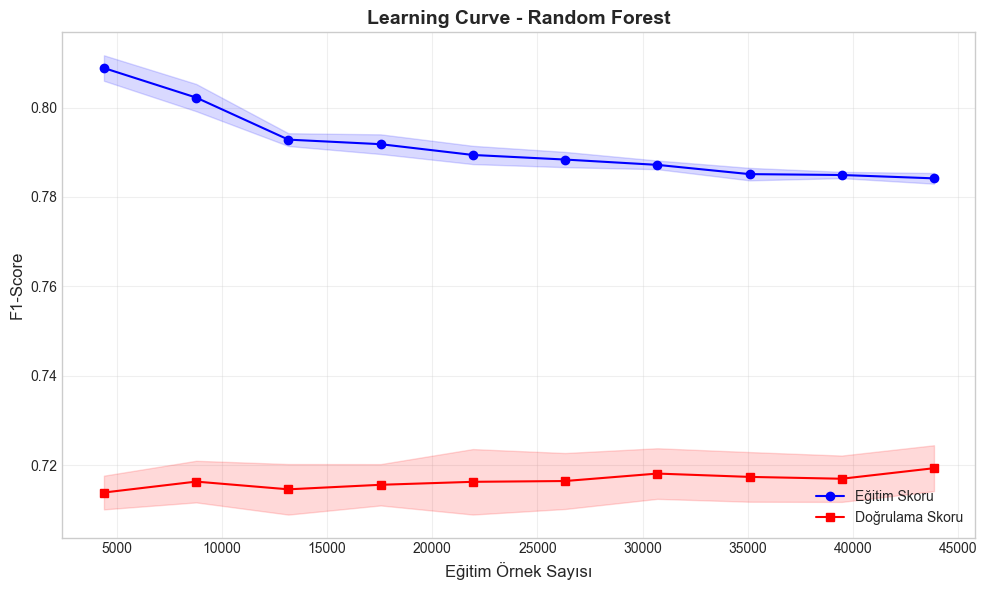


 Grafik kaydedildi: learning_curve.png

 Learning Curve Yorumu:
  - İki eğri birbirine yakınsa: Model iyi genelleştirebiliyor
  - Eğitim skoru yüksek, doğrulama skoru düşükse: Overfitting var
  - Her ikisi de düşükse: Underfitting var


In [24]:
from sklearn.model_selection import learning_curve
# Learning curve için model seçimi
model_for_lc = best_rf if 'best_rf' in locals() else best_gb
model_name = 'Random Forest' if 'best_rf' in locals() else 'Gradient Boosting'

print(f"\nLearning Curve Analizi başlıyor: {model_name}")

# Learning curve hesapla
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model_for_lc,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Ortalama ve standart sapma
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Eğitim Skoru')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, 's-', color='red', label='Doğrulama Skoru')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='red')

plt.xlabel('Eğitim Örnek Sayısı', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title(f'Learning Curve - {model_name}', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()

# Kaydet
Path('../results/figures').mkdir(parents=True, exist_ok=True)
plt.savefig('../results/figures/learning_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Yorum
print("\n Grafik kaydedildi: learning_curve.png")
print("\n Learning Curve Yorumu:")
print("  - İki eğri birbirine yakınsa: Model iyi genelleştirebiliyor")
print("  - Eğitim skoru yüksek, doğrulama skoru düşükse: Overfitting var")
print("  - Her ikisi de düşükse: Underfitting var")


## 5.9. Hiperparametre Sonuçlarının Kaydedilmesi

In [25]:
from pathlib import Path

# Klasör kontrolü
Path('../results').mkdir(parents=True, exist_ok=True)

file_path = '../results/hiperparametre_sonuclari.txt'
with open(file_path, 'w', encoding='utf-8') as f:

    f.write("HİPERPARAMETRE OPTİMIZASYONU SONUÇLARI\n")
    
    f.write(f"En İyi Model (önceki seçim): {best_model_name}\n")
    
    if 'best_rf' in locals():
        method = 'Grid Search CV' if 'grid_search_rf' in locals() else 'Randomized Search CV'
        f.write(f"Optimizasyon Yöntemi: {method}\n\n")
        f.write("En İyi Hiperparametreler (Random Forest):\n")
        for param, value in grid_search_rf.best_params_.items():
            f.write(f"  {param}: {value}\n")
    
    if 'best_gb' in locals():
        method = 'Randomized Search CV'
        f.write(f"\nOptimizasyon Yöntemi: {method}\n\n")
        f.write("En İyi Hiperparametreler (Gradient Boosting):\n")
        for param, value in random_search_gb.best_params_.items():
            f.write(f"  {param}: {value}\n")
    
    # Performans karşılaştırması
    f.write("\n" + "="*80 + "\n")
    f.write("PERFORMANS KARŞILAŞTIRMASI\n")
    f.write("="*80 + "\n\n")
    f.write(comparison.to_string(index=False))
    f.write("\n\n")
    
    # Özellik önemleri
    if 'feature_importance' in locals():
        f.write("="*80 + "\n")
        f.write("ÖZELLİK ÖNEMLERİ\n")
        f.write("="*80 + "\n\n")
        f.write(feature_importance.to_string(index=False))

print(f"\n Sonuçlar kaydedildi: {file_path}")


 Sonuçlar kaydedildi: ../results/hiperparametre_sonuclari.txt
